In [3]:
import scanpy as sc
import infercnvpy as cnv
import matplotlib.pyplot as plt
import warnings

In [4]:
adata = sc.read_h5ad("/home/augusta/SSS_mount/insituCNV/data/WTx-CosMx_TVA/snPATHO-seq/adata_snPATHOseq_B197.h5ad")

In [5]:
adata

AnnData object with n_obs × n_vars = 39075 × 15502
    obs: 'library', 'barcode', 'sid', 'sum', 'detected', 'subsets_mt_sum', 'subsets_mt_detected', 'subsets_mt_percent', 'total', 'sizeFactor', 'kid_lv1', 'lab_lv1', 'kid_lv2', 'lab_lv2', 'dataset', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'leiden'
    var: 'gene_id', 'gene_symbol', 'chromosome', 'start', 'end', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'dataset_colors', 'hvg', 'lab_lv1_colors', 'lab_lv2_colors', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'PCA', 'UMAP', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'logcounts', 'raw'
   

### Smooth the data

In [1]:
import warnings
import numpy as np
from scipy.sparse import csr_matrix, issparse
from scvelo import logging as logg
from scvelo import settings
from scvelo.preprocessing.neighbors import get_connectivities, get_n_neighs, neighbors, verify_neighbors
from scvelo.preprocessing.utils import normalize_per_cell, not_yet_normalized


def moments(
    data,
    n_neighbors=30,
    n_pcs=None,
    mode="connectivities",
    method="umap",
    use_rep=None,
    use_highly_variable=True,
    copy=False,
):
    """Computes moments for velocity estimation.

    First-/second-order moments are computed for each cell across its nearest neighbors,
    where the neighbor graph is obtained from euclidean distances in PCA space.

    Arguments:
    ---------
    data: :class:`~anndata.AnnData`
        Annotated data matrix.
    n_neighbors: `int` (default: 30)
        Number of neighbors to use.
    n_pcs: `int` (default: None)
        Number of principal components to use.
        If not specified, the full space is used of a pre-computed PCA,
        or 30 components are used when PCA is computed internally.
    mode: `'connectivities'` or `'distances'`  (default: `'connectivities'`)
        Distance metric to use for moment computation.
    method : {{'umap', 'hnsw', 'sklearn', `None`}}  (default: `'umap'`)
        Method to compute neighbors, only differs in runtime.
        Connectivities are computed with adaptive kernel width as proposed in
        Haghverdi et al. 2016 (https://doi.org/10.1038/nmeth.3971).
    use_rep : `None`, `'X'` or any key for `.obsm` (default: None)
        Use the indicated representation. If `None`, the representation is chosen
        automatically: for .n_vars < 50, .X is used, otherwise ‘X_pca’ is used.
    use_highly_variable: `bool` (default: True)
        Whether to use highly variable genes only, stored in .var['highly_variable'].
    copy: `bool` (default: `False`)
        Return a copy instead of writing to adata.

    Returns
    -------
    Ms: `.layers`
        dense matrix with first order moments of spliced counts.
    Mu: `.layers`
        dense matrix with first order moments of unspliced counts.
    """
    adata = data.copy() if copy else data

    layers = [layer for layer in {"raw"} if layer in adata.layers]
    if any([not_yet_normalized(adata.layers[layer]) for layer in layers]):
        normalize_per_cell(adata)

    if n_neighbors is not None and n_neighbors > get_n_neighs(adata):
        warnings.warn(
            "Automatic neighbor calculation is deprecated since scvelo==0.4.0 and will be removed in a future version "
            "of scVelo. Please compute neighbors first with Scanpy.",
            DeprecationWarning,
            stacklevel=2,
        )
        neighbors(
            adata,
            n_neighbors=n_neighbors,
            use_rep=use_rep,
            use_highly_variable=use_highly_variable,
            n_pcs=n_pcs,
            method=method,
        )
    verify_neighbors(adata)

    if "spliced" not in adata.layers.keys() or "unspliced" not in adata.layers.keys():
        logg.info(f"computing moments based on {mode}", r=True)
        connectivities = get_connectivities(
            adata, mode, n_neighbors=n_neighbors, recurse_neighbors=False
        )
        adata.layers["Ms"] = (
            csr_matrix.dot(connectivities, csr_matrix(adata.layers["raw"]))
            .astype(np.float32)
            .toarray()
        )
    return adata if copy else None

In [ ]:
adata

In [6]:
moments(adata)

computing neighbors


/tmp/ipykernel_1095587/2636235369.py:1: DeprecationWarning: Automatic neighbor calculation is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors first with Scanpy.
  moments(adata)
/tmp/ipykernel_1095587/3457130136.py:69: DeprecationWarning: `neighbors` is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors with Scanpy.
  neighbors(


    finished (0:00:31) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities


In [7]:
adata

AnnData object with n_obs × n_vars = 39075 × 15502
    obs: 'library', 'barcode', 'sid', 'sum', 'detected', 'subsets_mt_sum', 'subsets_mt_detected', 'subsets_mt_percent', 'total', 'sizeFactor', 'kid_lv1', 'lab_lv1', 'kid_lv2', 'lab_lv2', 'dataset', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'leiden', 'n_counts'
    var: 'gene_id', 'gene_symbol', 'chromosome', 'start', 'end', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'dataset_colors', 'hvg', 'lab_lv1_colors', 'lab_lv2_colors', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'PCA', 'UMAP', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'logcounts

In [8]:
adata.layers['Ms']

array([[ 0.        ,  0.3854167 ,  0.0625    , ...,  1.25      ,
        13.958334  ,  5.8958335 ],
       [ 0.        ,  0.0625    ,  0.        , ...,  0.2916667 ,
         3.2708335 ,  1.4166667 ],
       [ 0.        ,  0.34375   ,  0.09375   , ...,  2.125     ,
        11.9375    ,  9.8125    ],
       ...,
       [ 0.07692308,  0.15384616,  0.05128205, ...,  0.23076923,
         2.128205  ,  1.923077  ],
       [ 0.02777778,  0.25      ,  0.08333334, ...,  0.25      ,
         3.6666667 ,  2.4166667 ],
       [ 0.        ,  0.33333334,  0.        , ...,  1.939394  ,
        13.757576  ,  7.969697  ]], dtype=float32)

#### Preprocessing

In [4]:
adata.layers['logtransformed'] = adata.layers['raw'].copy()

In [5]:
sc.pp.normalize_total(adata, layer = 'logtransformed')

In [6]:
sc.pp.log1p(adata, layer = 'logtransformed')

In [7]:
print(adata.layers['raw'])

  (0, 1)	1.0
  (0, 7)	3.0
  (0, 13)	7.0
  (0, 19)	1.0
  (0, 20)	2.0
  (0, 21)	1.0
  (0, 23)	3.0
  (0, 25)	2.0
  (0, 26)	8.0
  (0, 33)	3.0
  (0, 37)	2.0
  (0, 39)	2.0
  (0, 40)	2.0
  (0, 46)	1.0
  (0, 47)	1.0
  (0, 48)	4.0
  (0, 51)	1.0
  (0, 53)	1.0
  (0, 57)	1.0
  (0, 59)	2.0
  (0, 66)	1.0
  (0, 73)	1.0
  (0, 75)	1.0
  (0, 78)	1.0
  (0, 83)	1.0
  :	:
  (39074, 14609)	1.0
  (39074, 14643)	1.0
  (39074, 14650)	1.0
  (39074, 14663)	1.0
  (39074, 14689)	1.0
  (39074, 14705)	1.0
  (39074, 14715)	1.0
  (39074, 14724)	1.0
  (39074, 14738)	1.0
  (39074, 14777)	1.0
  (39074, 14787)	1.0
  (39074, 14799)	1.0
  (39074, 14831)	2.0
  (39074, 14835)	1.0
  (39074, 14846)	1.0
  (39074, 14873)	1.0
  (39074, 14920)	1.0
  (39074, 14936)	1.0
  (39074, 14977)	3.0
  (39074, 15000)	1.0
  (39074, 15026)	2.0
  (39074, 15046)	1.0
  (39074, 15081)	2.0
  (39074, 15485)	1.0
  (39074, 15495)	3.0


In [8]:
print(adata.layers['logtransformed'])

  (0, 1)	0.13890076553140607
  (0, 7)	0.36951333120874147
  (0, 13)	0.7144538285017645
  (0, 19)	0.13890076553140607
  (0, 20)	0.26084013887330804
  (0, 21)	0.13890076553140607
  (0, 23)	0.36951333120874147
  (0, 25)	0.26084013887330804
  (0, 26)	0.7848511309720636
  (0, 33)	0.36951333120874147
  (0, 37)	0.26084013887330804
  (0, 39)	0.26084013887330804
  (0, 40)	0.26084013887330804
  (0, 46)	0.13890076553140607
  (0, 47)	0.13890076553140607
  (0, 48)	0.4675257441776115
  (0, 51)	0.13890076553140607
  (0, 53)	0.13890076553140607
  (0, 57)	0.13890076553140607
  (0, 59)	0.26084013887330804
  (0, 66)	0.13890076553140607
  (0, 73)	0.13890076553140607
  (0, 75)	0.13890076553140607
  (0, 78)	0.13890076553140607
  (0, 83)	0.13890076553140607
  :	:
  (39074, 14609)	1.253874079720791
  (39074, 14643)	1.253874079720791
  (39074, 14650)	1.253874079720791
  (39074, 14663)	1.253874079720791
  (39074, 14689)	1.253874079720791
  (39074, 14705)	1.253874079720791
  (39074, 14715)	1.253874079720791
  (3

#### Infer CNV

In [9]:
# We provide all immune cell types as "normal cells".
cnv.tl.infercnv(
    adata,
    layer = 'Ms',
    window_size=200,
    reference_key = 'dataset',
    reference_cat = ['imm', 'str']
)
# We provide immune and stromal cells as "normal cells".

100%|████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:20<00:00,  2.55s/it]


#### Cluster cells based on their CNV profile

In [10]:
cnv.tl.pca(adata)
cnv.pp.neighbors(adata)

cnv.tl.leiden(adata,resolution=0.2)

#### Plot CNV heatmaps

categories: 0, 1, 2, etc.
var_group_labels: chr1, chr2, chr3, etc.


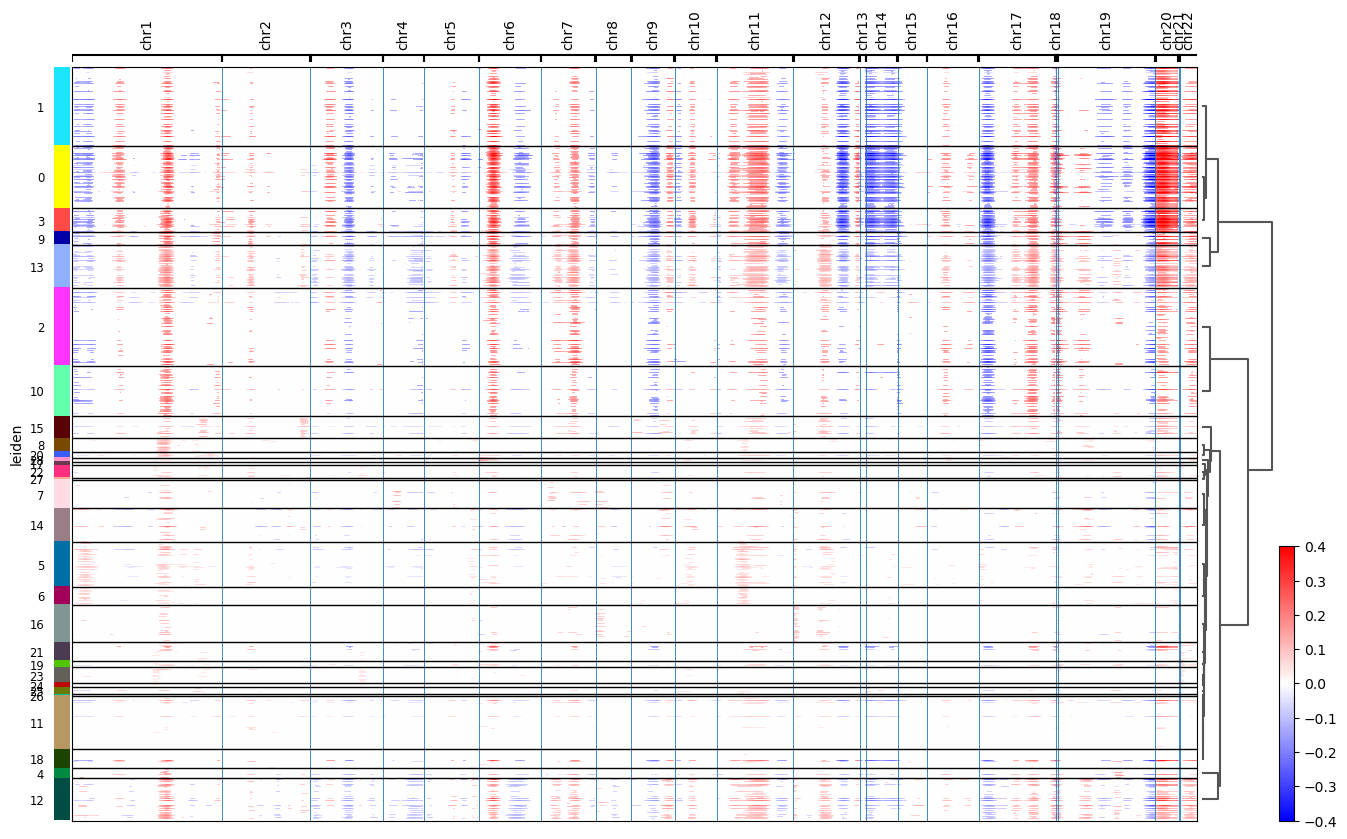

In [11]:
cnv.pl.chromosome_heatmap(adata, groupby="leiden", dendrogram=True, vmax = 0.4, vmin=-0.4)

categories: epi, imm, str
var_group_labels: chr1, chr2, chr3, etc.


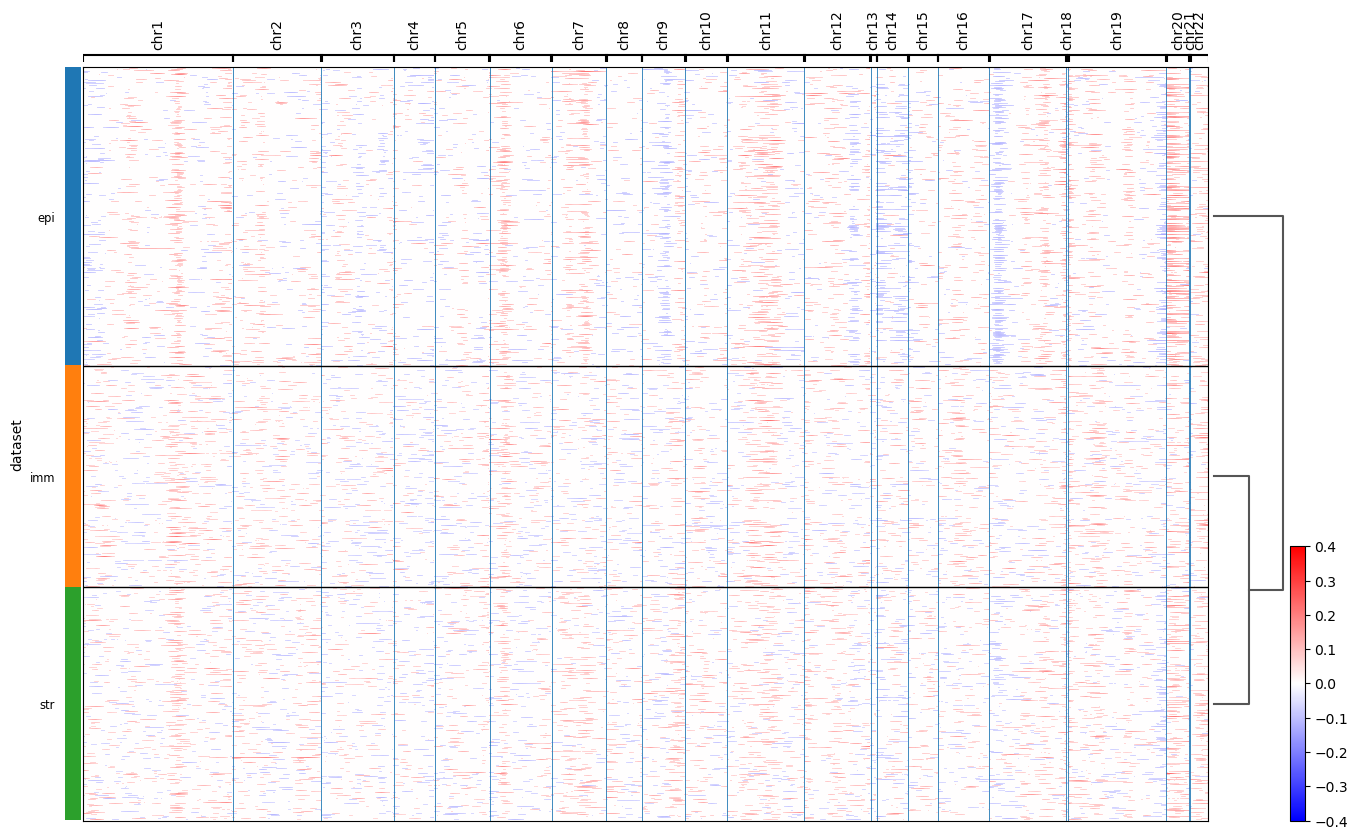

In [52]:
# logcounts
cnv.pl.chromosome_heatmap(adata, groupby="dataset", dendrogram=True, vmax = 0.4, vmin=-0.4)

categories: epi, imm, str
var_group_labels: chr1, chr2, chr3, etc.


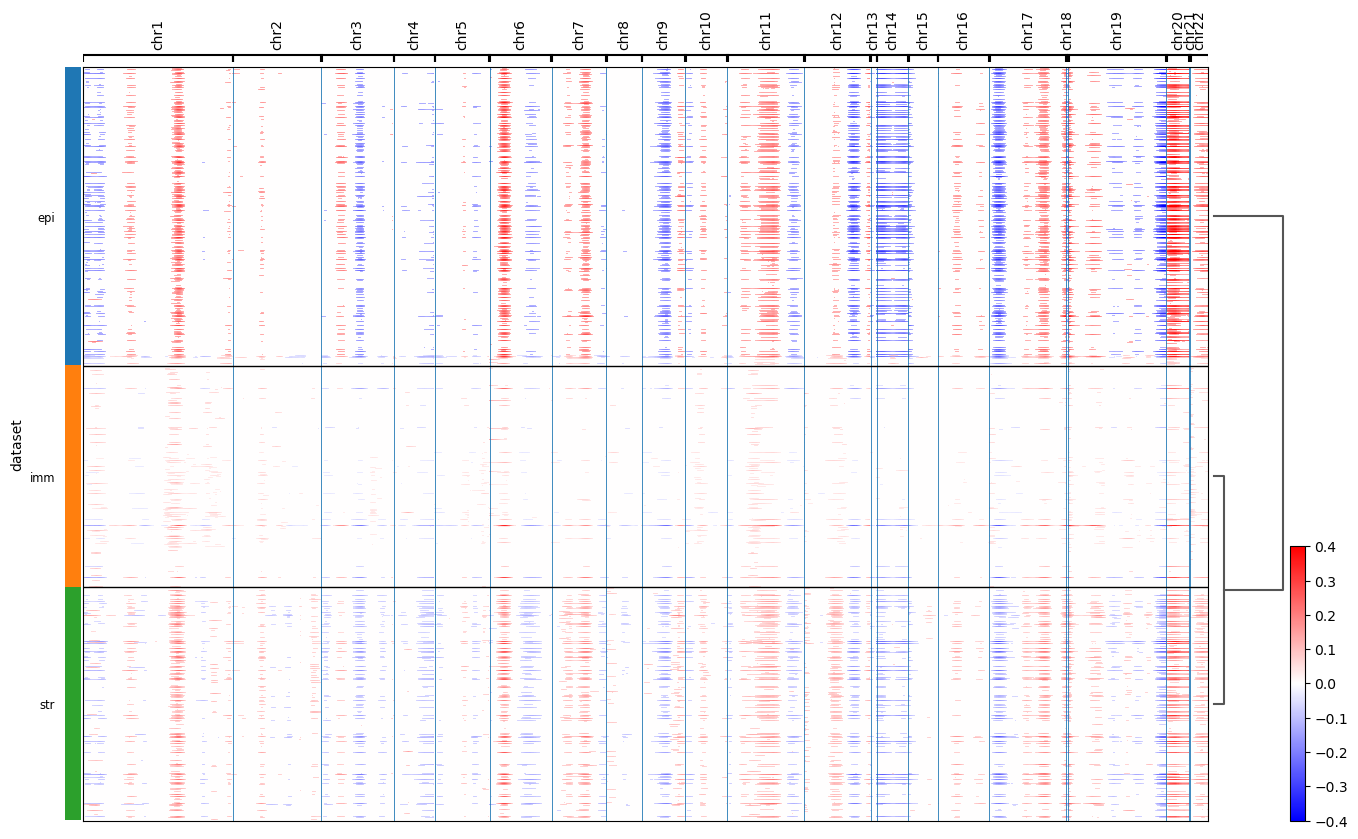

In [12]:
# Ms
cnv.pl.chromosome_heatmap(adata, groupby="dataset", dendrogram=True, vmax = 0.4, vmin=-0.4)

In [16]:
sc.tl.dendrogram(adata, groupby ='cnv_leiden')

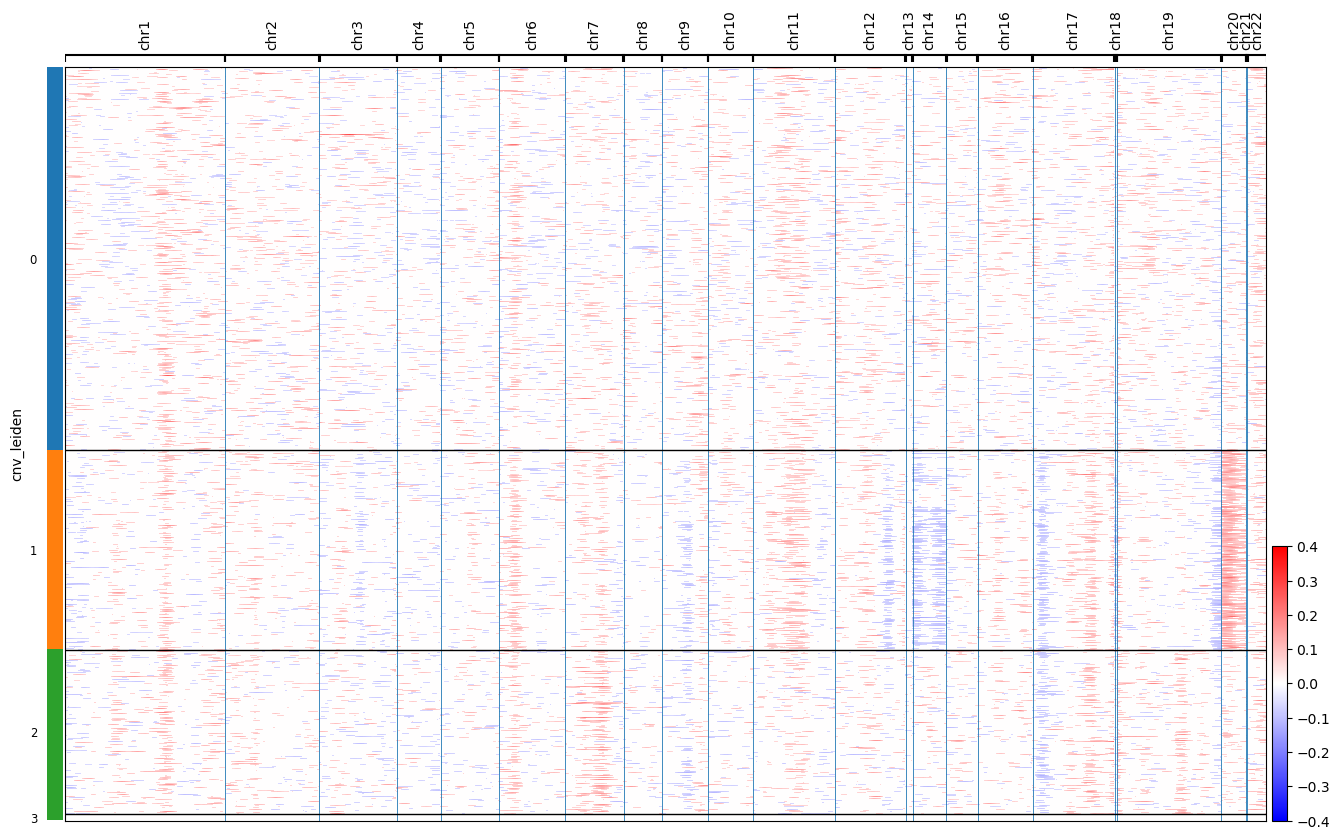

In [54]:
# logcounts
cnv.pl.chromosome_heatmap(adata, groupby="cnv_leiden", dendrogram=False,  vmin=-0.4, vmax=0.4)

categories: 0, 1, 2, etc.
var_group_labels: chr1, chr2, chr3, etc.


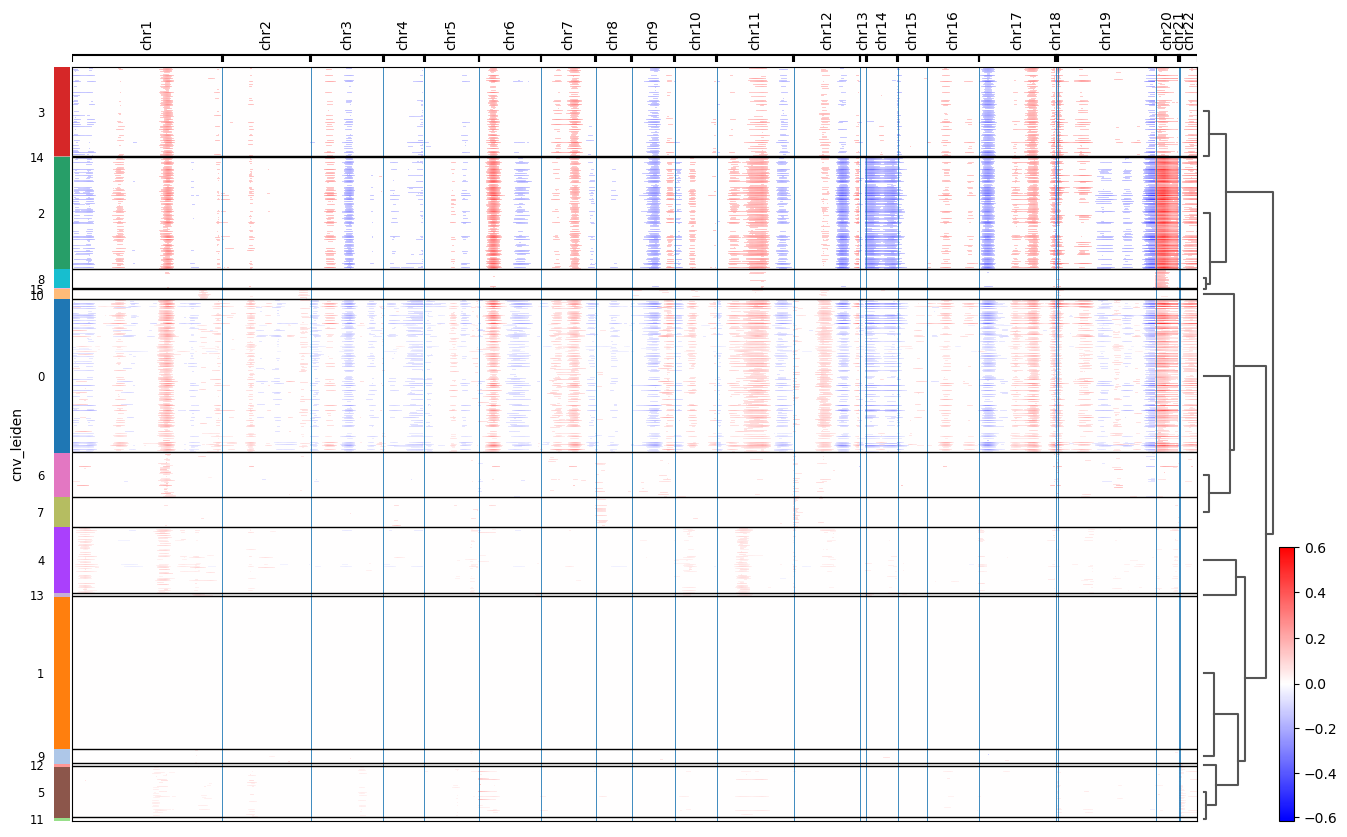

In [17]:
# Ms
cnv.pl.chromosome_heatmap(adata, groupby="cnv_leiden", dendrogram=True)

In [24]:
adata.obs.dataset

c_1_1_5_epi        epi
c_1_1_8_epi        epi
c_1_1_11_epi       epi
c_1_1_13_epi       epi
c_1_1_14_epi       epi
                  ... 
c_2_2_10405_str    str
c_2_2_10406_str    str
c_2_2_10411_str    str
c_2_2_10414_str    str
c_2_2_10416_str    str
Name: dataset, Length: 39075, dtype: category
Categories (3, object): ['epi', 'imm', 'str']

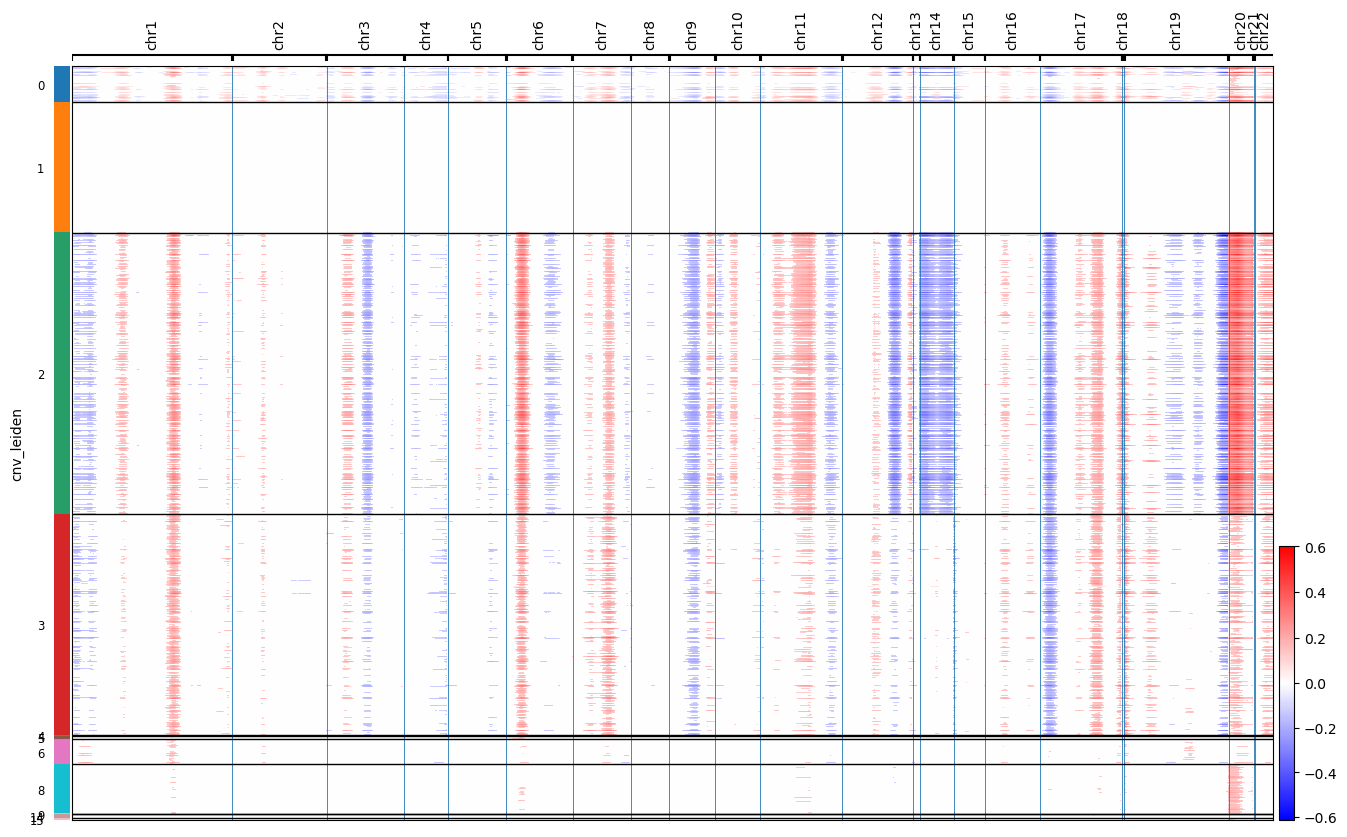

In [27]:
# Ms
cnv.pl.chromosome_heatmap(adata[adata.obs['dataset'] == 'epi'], groupby="cnv_leiden", dendrogram=False)

In [72]:
adata[adata.obs['cnv_leiden'] != '3']

View of AnnData object with n_obs × n_vars = 38747 × 15502
    obs: 'library', 'barcode', 'sid', 'sum', 'detected', 'subsets_mt_sum', 'subsets_mt_detected', 'subsets_mt_percent', 'total', 'sizeFactor', 'kid_lv1', 'lab_lv1', 'kid_lv2', 'lab_lv2', 'dataset', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'leiden', 'cnv_leiden'
    var: 'gene_id', 'gene_symbol', 'chromosome', 'start', 'end', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'dataset_colors', 'hvg', 'lab_lv1_colors', 'lab_lv2_colors', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap', 'cnv', 'cnv_neighbors', 'cnv_leiden', 'dendrogram_leiden', 'dendrogram

In [67]:
len(adata[adata.obs['cnv_leiden'] == '2'])

8529

/home/augusta/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/anndata/_core/storage.py:85: ImplicitModificationWarning: X should not be a np.matrix, use np.ndarray instead.
  warnings.warn(msg, ImplicitModificationWarning)
... storing 'cnv_leiden' as categorical


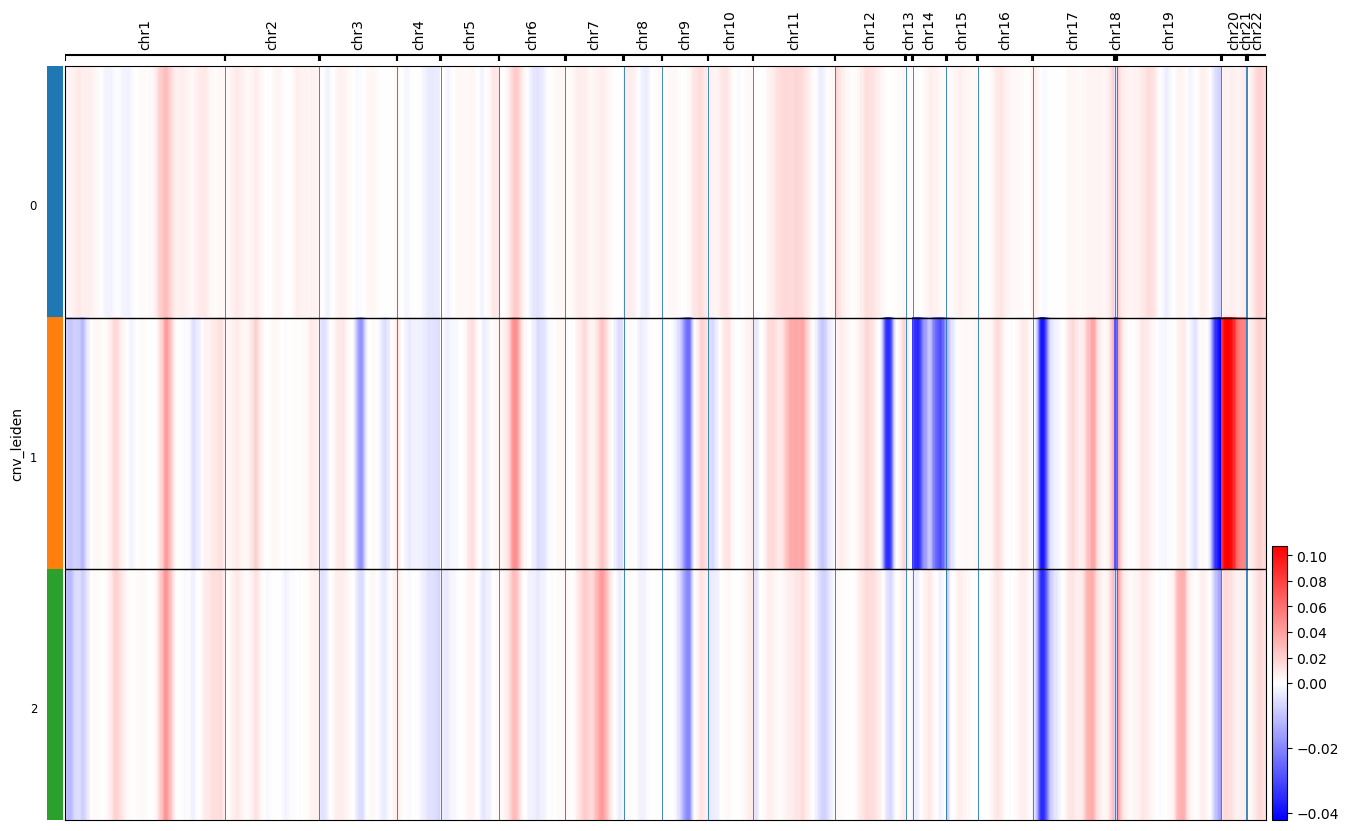

In [78]:
# logcounts
cnv.pl.chromosome_heatmap_summary(adata[adata.obs['cnv_leiden'] != '3'], groupby="cnv_leiden", dendrogram=False)

... storing 'cnv_leiden' as categorical


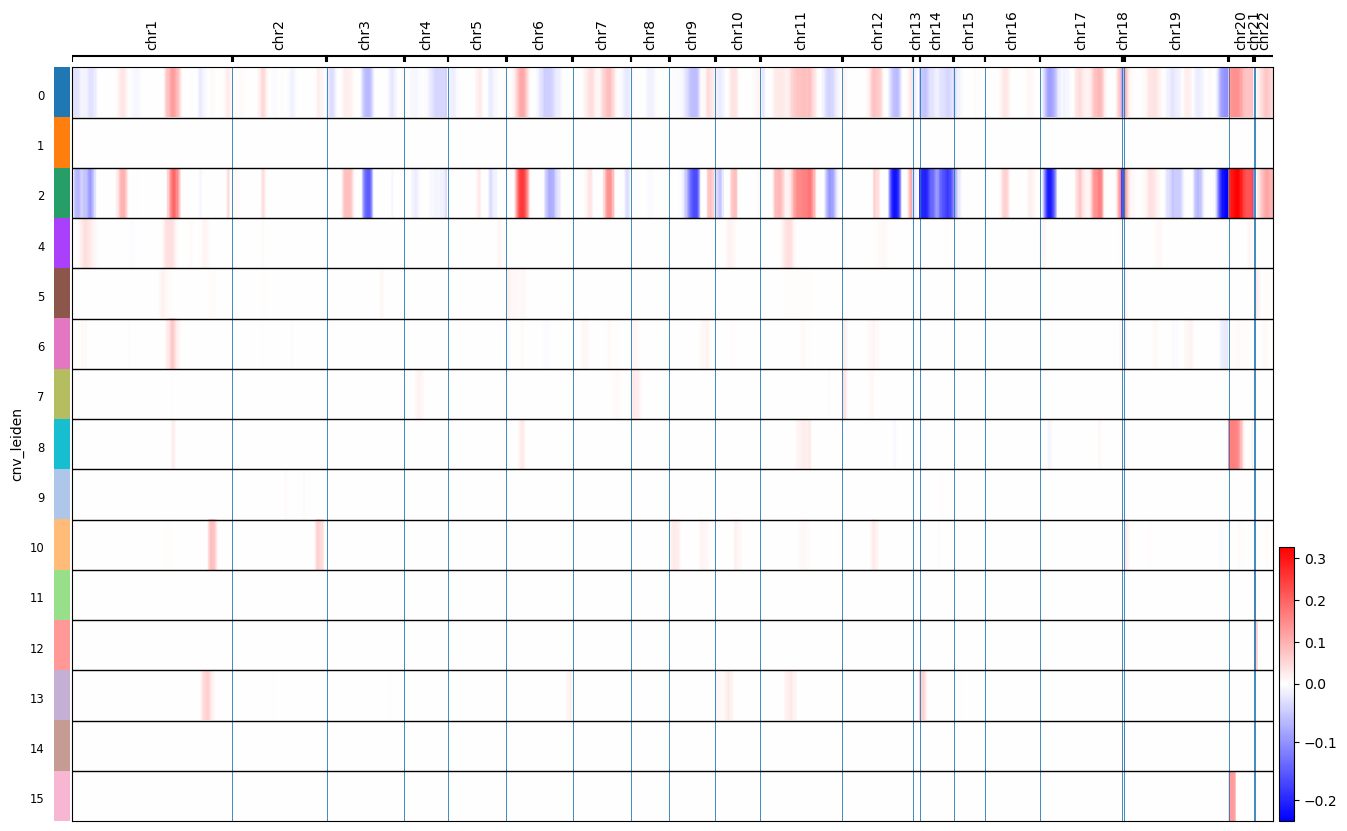

In [20]:
# logcounts
cnv.pl.chromosome_heatmap_summary(adata[adata.obs['cnv_leiden'] != '3'], groupby="cnv_leiden", dendrogram=False)

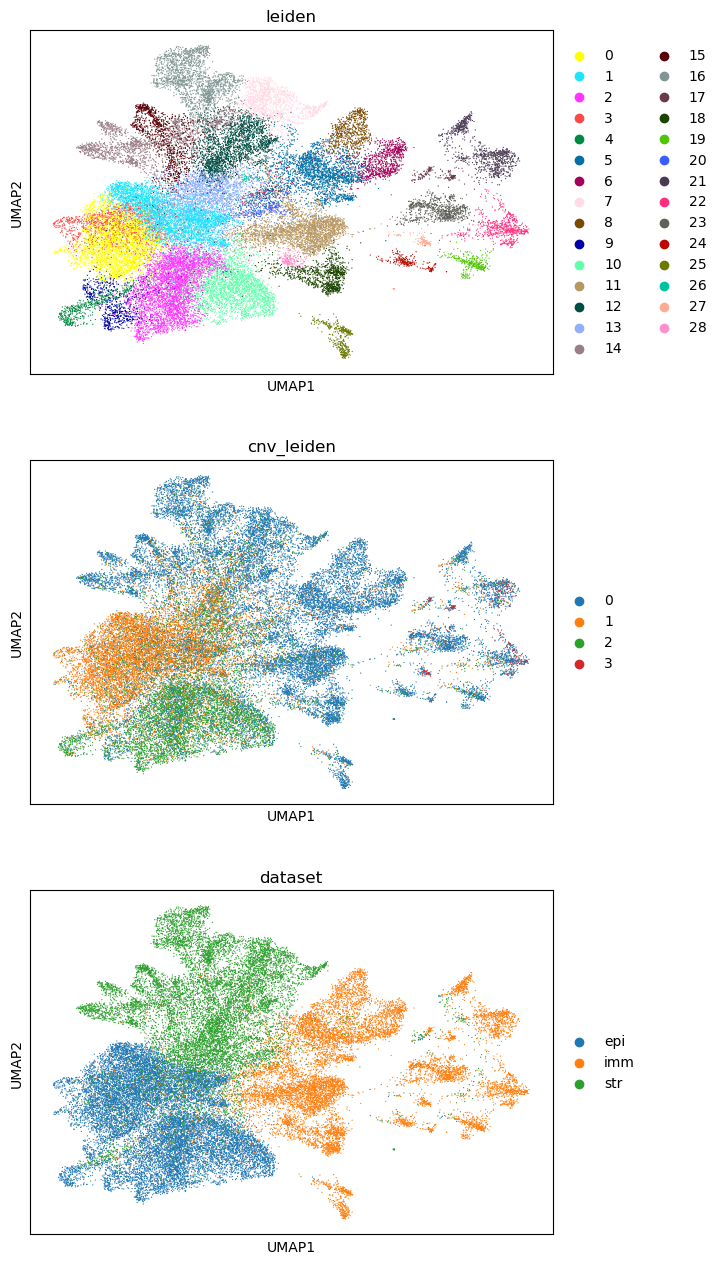

In [57]:
# raw
sc.pl.umap(adata, color = ['leiden', 'cnv_leiden', 'dataset'], ncols=1)